In [1]:
import numpy as np
import pandas as pd
import time
from math import ceil
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('2017EE30515.csv',header=None)

In [3]:
X = data.iloc[:,:784]/255
t = data.iloc[:,784]

In [4]:
def softmax(z):
    z = z - np.max(z)
    expz = np.exp(z)
    return expz/np.sum(expz,axis=1,keepdims=True)

def sigmoid(z):
    return 1/(1+np.exp(-1*z))

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0,z)

def d_sigmoid(z):
    return sigmoid(z)*(1-sigmoid(z))

def d_relu(z):
    z[z>0] = 1
    z[z<=0] = 0
    return z

def d_tanh(z):
    return 1 - np.square(np.tanh(z))

In [5]:
def initialize(hidden_units,hl):
    w = [np.random.randn(784,hidden_units[0])]
    b = [np.random.randn(hidden_units[0])]
    z = [0]*(hl+1)
    a = [0]*(hl)
    delta = [0]*(hl+1)
    dw = [0]*(hl+1)
    db = [0]*(hl+1)
    
    return w,b,z,a,delta,dw,db

In [6]:
def forward(X_batch,w,b,z,a,hl,act_func):

    z[0] = np.dot(X_batch,w[0])+b[0]
    if act_func is 'sigmoid':
        a[0] = sigmoid(z[0])
    if act_func is 'relu':
        a[0] = relu(z[0])
    if act_func is 'tanh':
        a[0] = tanh(z[0])
    for i in range(1,hl):
        z[i] = np.dot(a[i-1],w[i])+b[i]
        if act_func is 'sigmoid':
            a[i] = sigmoid(z[i])
        if act_func is 'relu':
            a[i] = relu(z[i])
        if act_func is 'tanh':
            a[i] = tanh(z[i])
    
    z[hl] = np.dot(a[hl-1],w[hl])+b[hl]
    
    return z,a

def backward(X_batch,t_batch,dw,db,y,a,w,b,delta,lambd,hl,act_func):
    batch_size = len(X_batch)
    delta[hl] = y - t_batch
    dw[hl] = (np.dot(a[hl-1].T,delta[hl]) + lambd*w[hl])/batch_size
    db[hl] = (np.sum(delta[hl],axis=0))/batch_size
    for i in range(hl-1,-1,-1):
        temp = np.dot(delta[i+1],w[i+1].T)
        if act_func is 'sigmoid':
            der = d_sigmoid(a[i])
        if act_func is 'relu':
            der = d_relu(a[i])
        if act_func is 'tanh':
            der = d_tanh(a[i])
            
        delta[i] = der*temp
        if i == 0:
            dw[i] = (np.dot(X_batch.T,delta[i]) + lambd*w[i])/batch_size
        else:
            dw[i] = (np.dot(a[i-1].T,delta[i]) + lambd*w[i])/batch_size
        db[i] = np.sum(delta[i],axis=0)/batch_size
        
    return dw,db

In [7]:
def predict(X,w,b,hl,act_func):
    z = [0]*(hl+1)
    a = [0]*(hl+1)
    z,a = forward(X,w,b,z,a,hl,act_func)

    return softmax(z[-1])

In [8]:
def accuracy(y,t):
    y = np.argmax(y,axis=1)
    t = np.argmax(t,axis=1)
    diff = (y == t)

    return np.sum(diff)/len(diff)

In [9]:
def nn(X,t,epochs,hidden_units,learning_rate,batch_size,act_func,hl,lambd=0,verbose=0):
    np.random.seed(42)
    
    
    assert(len(hidden_units)==hl)
    
    X_train = np.array(X[:2700])
    X_val = np.array(X[2700:])

    t_train = np.array(t[:2700])
    t_val = np.array(t[2700:])

    t_train_oh = np.zeros((len(t_train),10))
    t_val_oh = np.zeros((len(t_val),10))
    t_train_oh[np.arange(len(t_train)),t_train] = 1
    t_val_oh[np.arange(len(t_val)),t_val] = 1
    
    #print(epochs,hidden_units,learning_rate,batch_size)
    
    w,b,z,a,delta,dw,db = initialize(hidden_units,hl)
    
    for i in range(1,hl):
        w.append(np.random.randn(hidden_units[i-1],hidden_units[i]))
        b.append(np.random.randn(hidden_units[i]))
        
    w.append(0.1*np.random.randn(hidden_units[-1],10))
    b.append(np.random.randn(10))
    
    
    tr_errs = []
    tr_accs = []
    val_errs = []
    val_accs = []
    
    best_val_acc = 0.0
    best = dict()

    num_batches = ceil(len(X_train)/batch_size)
    X_splits = np.array_split(X_train,num_batches)
    t_splits = np.array_split(t_train_oh,num_batches)

    for i in range(epochs):
        time1 = time.time()
        for j in range(num_batches):
            X_batch = X_splits[j]
            t_batch = t_splits[j]
            
            z,a = forward(X_batch,w,b,z,a,hl,act_func)
            y = softmax(z[-1])
            
            dw,db = backward(X_batch,t_batch,dw,db,y,a,w,b,delta,lambd,hl,act_func)
            
            for k in range(hl+1):
                w[k] = w[k] - learning_rate*dw[k]
                b[k] = b[k] - learning_rate*db[k]

        time2 = time.time()
        
        w_sq = np.square(np.array(w))
        w_sum = 0
        for k in range(len(w_sq)):
            w_sum += np.sum(w_sq[k])
        
        y_train = predict(X_train,w,b,hl,act_func)
        tr_acc = accuracy(y_train,t_train_oh)
        tr_err = -1*np.sum(t_train_oh*np.log(y_train))/len(X_train)

        y_val = predict(X_val,w,b,hl,act_func)
        val_acc = accuracy(y_val,t_val_oh)
        val_err = -1*np.sum(t_val_oh*np.log(y_val))/len(X_val)
        
    
        if verbose:
            print('epoch: %d/%d' %(i+1,epochs))
            print('time: %1.4f sec  training acc: %1.4f  validation acc: %1.4f' %(time2-time1,tr_acc,val_acc))
        if val_acc > best_val_acc:
            best['epoch'] = i+1
            #best['training acc'] = tr_acc
            best['validation acc'] = val_acc
            best_val_acc = val_acc
        
        tr_errs.append(tr_err)
        tr_accs.append(tr_acc)
        val_errs.append(val_err)
        val_accs.append(val_acc)
    
    params = [w,b]
    return tr_accs,val_accs,tr_errs,val_errs,params,best

In [11]:
# 1 hidden layer
hl = 1
lambd = 0
epochs = 20
act_fs = ['sigmoid','relu','tanh']
bsz = [100,300,500,1000,2700]
hu = [[25],[50],[100]]
lrs = [1e-2,5e-2,1e-3,5e-3]

models1 = pd.DataFrame(columns=['hidden layers','activation fnc','batch size','hidden units','learning rate','training acc','validation acc','best accs'])

for act_func in act_fs:
    for batch_size in bsz:
        for hidden_units in hu:
            for learning_rate in lrs:
                tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,epochs,hidden_units,learning_rate,batch_size,act_func,hl,lambd,verbose=0)
                models1 = models1.append(pd.Series([1,act_func,batch_size,hidden_units,learning_rate,tr_accs[-1],val_accs[-1],best],index=models1.columns),ignore_index=True)

In [12]:
models1 = models1.sort_values('validation acc',ascending=False)
models1.head(15)

,hidden layers,activation fnc,batch size,hidden units,learning rate,training acc,validation acc,best accs
129,1,tanh,100,[100],0.050,0.852963,0.816667,"{'epoch': 20, 'validation acc': 0.816666666666..."
81,1,relu,300,[100],0.050,0.866667,0.803333,"{'epoch': 14, 'validation acc': 0.813333333333..."
69,1,relu,100,[100],0.050,0.851852,0.790000,"{'epoch': 17, 'validation acc': 0.806666666666..."
68,1,relu,100,[100],0.010,0.854444,0.776667,"{'epoch': 18, 'validation acc': 0.776666666666..."
9,1,sigmoid,100,[100],0.050,0.816296,0.766667,"{'epoch': 20, 'validation acc': 0.766666666666..."
64,1,relu,100,[50],0.010,0.780000,0.753333,"{'epoch': 20, 'validation acc': 0.753333333333..."
141,1,tanh,300,[100],0.050,0.789630,0.750000,"{'epoch': 20, 'validation acc': 0.75}"
71,1,relu,100,[100],0.005,0.811111,0.746667,"{'epoch': 18, 'validation acc': 0.746666666666..."
65,1,relu,100,[50],0.050,0.800000,0.740000,"{'epoch': 19, 'validation acc': 0.74}"
93,1,relu,500,[100],0.050,0.798148,0.736667,"{'epoch': 19, 'validation acc': 0.776666666666..."


In [13]:
# 2 hidden layers
hl = 2
lambd = 0
epochs = 20
act_fs = ['sigmoid','relu','tanh']
bsz = [100,300,500]
hu = [[50,25],[75,30],[100,50]]
lrs = [1e-2,5e-2,1e-3,5e-3]

models2 = pd.DataFrame(columns=['hidden layers','activation fnc','batch size','hidden units','learning rate','training acc','validation acc','best accs'])

for act_func in act_fs:
    for batch_size in bsz:
        for hidden_units in hu:
            for learning_rate in lrs:
                tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,epochs,hidden_units,learning_rate,batch_size,act_func,hl,lambd,verbose=0)
                models2 = models2.append(pd.Series([2,act_func,batch_size,hidden_units,learning_rate,tr_accs[-1],val_accs[-1],best],index=models2.columns),ignore_index=True)

In [14]:
models2 = models2.sort_values('validation acc',ascending=False)
models2.head(15)

,hidden layers,activation fnc,batch size,hidden units,learning rate,training acc,validation acc,best accs
81,2,tanh,100,"[100, 50]",0.050,0.847037,0.820000,"{'epoch': 19, 'validation acc': 0.82}"
9,2,sigmoid,100,"[100, 50]",0.050,0.727778,0.743333,"{'epoch': 20, 'validation acc': 0.743333333333..."
77,2,tanh,100,"[75, 30]",0.050,0.786667,0.726667,"{'epoch': 19, 'validation acc': 0.726666666666..."
73,2,tanh,100,"[50, 25]",0.050,0.756296,0.703333,"{'epoch': 20, 'validation acc': 0.703333333333..."
93,2,tanh,300,"[100, 50]",0.050,0.724074,0.686667,"{'epoch': 20, 'validation acc': 0.686666666666..."
47,2,relu,100,"[100, 50]",0.005,0.623704,0.623333,"{'epoch': 11, 'validation acc': 0.63}"
105,2,tanh,500,"[100, 50]",0.050,0.657778,0.623333,"{'epoch': 20, 'validation acc': 0.623333333333..."
59,2,relu,300,"[100, 50]",0.005,0.648148,0.606667,"{'epoch': 20, 'validation acc': 0.606666666666..."
80,2,tanh,100,"[100, 50]",0.010,0.639259,0.603333,"{'epoch': 20, 'validation acc': 0.603333333333..."
68,2,relu,500,"[100, 50]",0.010,0.616296,0.593333,"{'epoch': 20, 'validation acc': 0.593333333333..."


In [15]:
models = pd.concat([models1,models2], ignore_index=True)
models = models.sort_values('validation acc',ascending=False)
models

,hidden layers,activation fnc,batch size,hidden units,learning rate,training acc,validation acc,best accs
180,2,tanh,100,"[100, 50]",0.050,0.847037,0.820000,"{'epoch': 19, 'validation acc': 0.82}"
0,1,tanh,100,[100],0.050,0.852963,0.816667,"{'epoch': 20, 'validation acc': 0.816666666666..."
1,1,relu,300,[100],0.050,0.866667,0.803333,"{'epoch': 14, 'validation acc': 0.813333333333..."
2,1,relu,100,[100],0.050,0.851852,0.790000,"{'epoch': 17, 'validation acc': 0.806666666666..."
3,1,relu,100,[100],0.010,0.854444,0.776667,"{'epoch': 18, 'validation acc': 0.776666666666..."
4,1,sigmoid,100,[100],0.050,0.816296,0.766667,"{'epoch': 20, 'validation acc': 0.766666666666..."
5,1,relu,100,[50],0.010,0.780000,0.753333,"{'epoch': 20, 'validation acc': 0.753333333333..."
6,1,tanh,300,[100],0.050,0.789630,0.750000,"{'epoch': 20, 'validation acc': 0.75}"
7,1,relu,100,[100],0.005,0.811111,0.746667,"{'epoch': 18, 'validation acc': 0.746666666666..."
181,2,sigmoid,100,"[100, 50]",0.050,0.727778,0.743333,"{'epoch': 20, 'validation acc': 0.743333333333..."


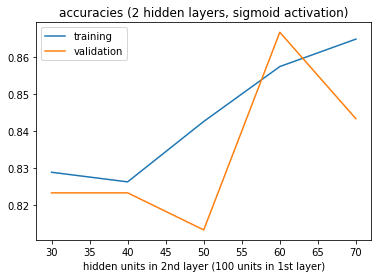

In [20]:
hu = [[100,30],[100,40],[100,50],[100,60],[100,70]]
act_func = 'sigmoid'
accs = []
for hidden_units in hu:
    tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,100,hidden_units,0.05,100,act_func,2,0,verbose=0)
    accs.append([tr_accs[-1],val_accs[-1]])
    
plt.figure()
plt.title('accuracies (2 hidden layers, ' + act_func + ' activation)')
plt.plot(np.array(hu)[:,1],np.array(accs)[:,0],label='training')
plt.plot(np.array(hu)[:,1],np.array(accs)[:,1],label='validation')
plt.xlabel('hidden units in 2nd layer (100 units in 1st layer)')
plt.legend()
plt.show()

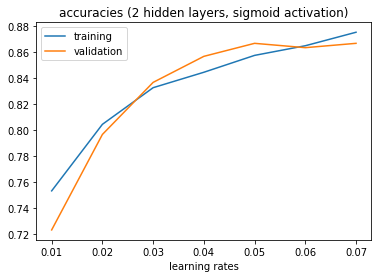

In [16]:
lrs = [0.01,0.02,0.03,0.04,0.05,0.06,0.07]
act_func = 'sigmoid'
accs = []
for learning_rate in lrs:
    tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,100,[100,60],learning_rate,100,act_func,2,0,verbose=0)
    accs.append([tr_accs[-1],val_accs[-1]])
    
plt.figure()
plt.title('accuracies (2 hidden layers, ' + act_func + ' activation)')
plt.plot(lrs,np.array(accs)[:,0],label='training')
plt.plot(lrs,np.array(accs)[:,1],label='validation')
plt.xlabel('learning rates')
plt.legend()
plt.show()

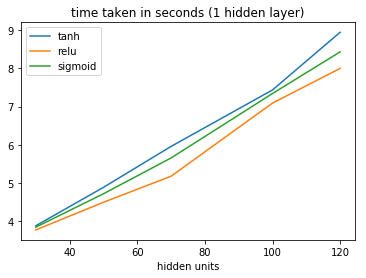

In [17]:
hu = [[30],[50],[70],[100],[120]]
act_funcs = ['tanh','relu','sigmoid']
times_t = []
times_r = []
times_s = []
for act_func in act_funcs:
    for hidden_units in hu:
        time1 = time.time()
        tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,100,hidden_units,0.05,100,act_func,1,0,verbose=0)
        time2 = time.time()
        if act_func is 'tanh':
            times_t.append(time2-time1)
        if act_func is 'relu':
            times_r.append(time2-time1)
        if act_func is 'sigmoid':
            times_s.append(time2-time1)

plt.figure()
plt.title('time taken in seconds (1 hidden layer)')
plt.plot(np.array(hu)[:,0],times_t,label='tanh')
plt.plot(np.array(hu)[:,0],times_r,label='relu')
plt.plot(np.array(hu)[:,0],times_s,label='sigmoid')
plt.xlabel('hidden units')
plt.legend()
plt.show()

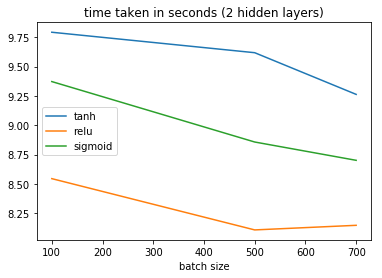

In [18]:
bsz = [100,500,700]
act_funcs = ['tanh','relu','sigmoid']
times_t = []
times_r = []
times_s = []
for act_func in act_funcs:
    for batch_size in bsz:
        time1 = time.time()
        tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,100,[100,60],0.05,batch_size,act_func,2,0,verbose=0)
        time2 = time.time()
        if act_func is 'tanh':
            times_t.append(time2-time1)
        if act_func is 'relu':
            times_r.append(time2-time1)
        if act_func is 'sigmoid':
            times_s.append(time2-time1)

plt.figure()
plt.title('time taken in seconds (2 hidden layers)')
plt.plot(bsz,times_t,label='tanh')
plt.plot(bsz,times_r,label='relu')
plt.plot(bsz,times_s,label='sigmoid')
plt.xlabel('batch size')
plt.legend()
plt.show()

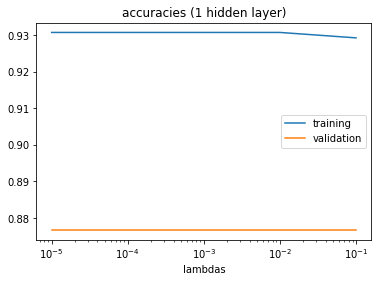

In [19]:
lambdas = [0.00001,0.001,0.01,0.1]
accs = []

for lambd in lambdas:
    tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,100,[120],0.04,100,'tanh',1,lambd,verbose=0)
    accs.append([tr_accs[-1],val_accs[-1]])
    
plt.figure()
plt.title('accuracies (1 hidden layer)')
plt.plot(lambdas,np.array(accs)[:,0],label='training')
plt.plot(lambdas,np.array(accs)[:,1],label='validation')
plt.xlabel('lambdas')
plt.legend()
plt.xscale('log')
plt.show()

In [21]:
tr_accs,val_accs,tr_errs,val_errs,params,best = nn(X,t,epochs=100,hidden_units=[120],learning_rate=0.04,batch_size=100,act_func='tanh',hl=1,lambd=0,verbose=1)

epoch: 1/100
time: 0.0768 sec  training acc: 0.4304  validation acc: 0.4267
epoch: 2/100
time: 0.0625 sec  training acc: 0.5985  validation acc: 0.6033
epoch: 3/100
time: 0.0625 sec  training acc: 0.6659  validation acc: 0.6733
epoch: 4/100
time: 0.0796 sec  training acc: 0.7130  validation acc: 0.7033
epoch: 5/100
time: 0.0569 sec  training acc: 0.7370  validation acc: 0.7200
epoch: 6/100
time: 0.0625 sec  training acc: 0.7567  validation acc: 0.7400
epoch: 7/100
time: 0.0652 sec  training acc: 0.7700  validation acc: 0.7733
epoch: 8/100
time: 0.0509 sec  training acc: 0.7796  validation acc: 0.7733
epoch: 9/100
time: 0.0625 sec  training acc: 0.7919  validation acc: 0.7767
epoch: 10/100
time: 0.0882 sec  training acc: 0.8037  validation acc: 0.7833
epoch: 11/100
time: 0.0625 sec  training acc: 0.8115  validation acc: 0.7900
epoch: 12/100
time: 0.0625 sec  training acc: 0.8174  validation acc: 0.7967
epoch: 13/100
time: 0.0698 sec  training acc: 0.8230  validation acc: 0.8000
epoch: 1

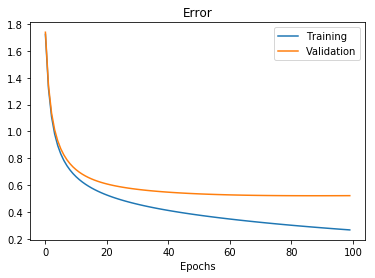

In [22]:
plt.figure()
plt.title('Error')
plt.plot(np.arange(len(tr_errs)),tr_errs,label='Training')
plt.plot(np.arange(len(val_errs)),val_errs,label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.show()

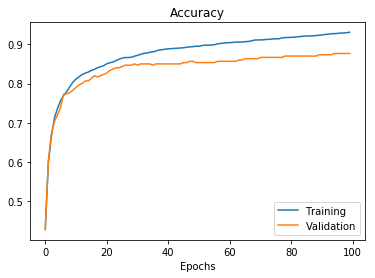

In [23]:
plt.figure()
plt.title('Accuracy')
plt.plot(np.arange(len(tr_accs)),tr_accs,label='Training')
plt.plot(np.arange(len(val_accs)),val_accs,label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.show()

In [24]:
w1 = params[0][0]
w2 = params[0][1]
b1 = params[1][0]
b2 = params[1][1]

In [25]:
X_train = np.array(X[:2700])
X_val = np.array(X[2700:])

t_train = np.array(t[:2700])
t_val = np.array(t[2700:])

t_train_oh = np.zeros((len(t_train),10))
t_val_oh = np.zeros((len(t_val),10))
t_train_oh[np.arange(len(t_train)),t_train] = 1
t_val_oh[np.arange(len(t_val)),t_val] = 1

In [26]:
a1 = tanh(np.dot(X_train,w1)+b1)
a2 = softmax(np.dot(a1,w2)+b2)
y = np.argmax(a2,axis=1)
diff = (y == t_train)

Actual: 6
Predicted: 6


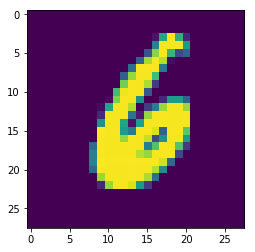

In [27]:
ex = 1
plt.imshow(X_train[ex].reshape(28,28).T)
print('Actual:',t_train[ex])
print('Predicted:',y[ex])

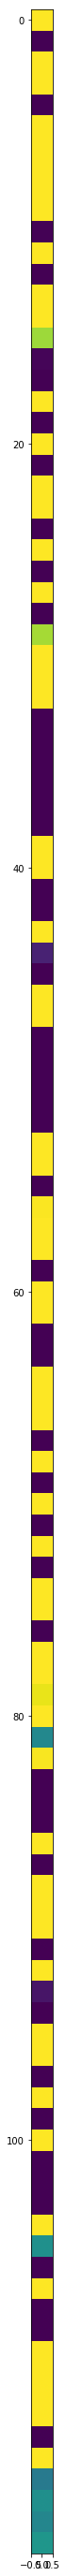

In [28]:
plt.figure(figsize=(5,50))
plt.imshow(a1[ex].reshape(120,1))

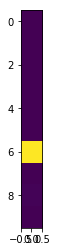

In [29]:
plt.imshow(a2[ex].reshape(10,1))

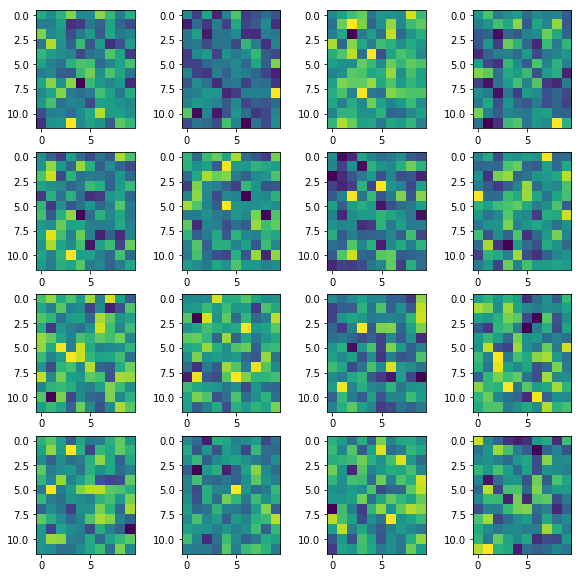

In [30]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(w1[i].reshape(12,10))

Label: 6


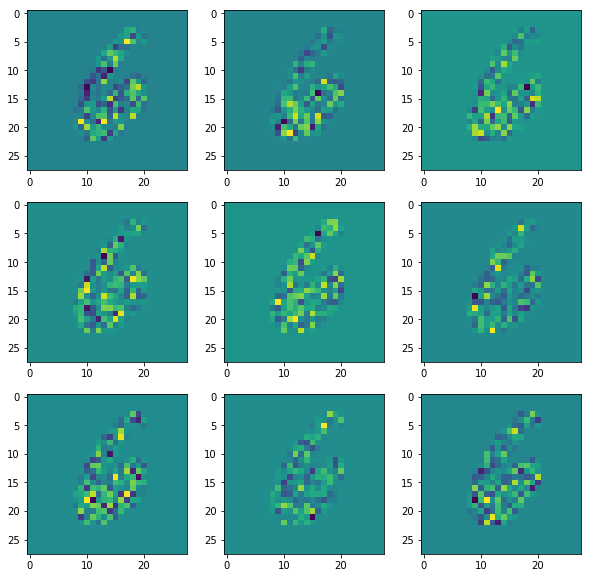

In [31]:
label = t_train[ex]
print('Label:',label)
activated = a1[ex].argsort()[::-1][:9]
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    repn = np.multiply(X_train[ex].reshape((28,28)),w1[:,activated[i]].reshape((28,28)))
    plt.imshow(repn.T)

In [32]:
a1 = tanh(np.dot(X_val,w1)+b1)
a2 = softmax(np.dot(a1,w2)+b2)
y = np.argmax(a2,axis=1)
diff = (y == t_val)

In [33]:
mis_X = X_val[np.logical_not(diff)]
mis_t = t_val[np.logical_not(diff)]
mis_y = y[np.logical_not(diff)]
print(mis_X.shape)

(37, 784)


Actual: 4
Predicted: 3


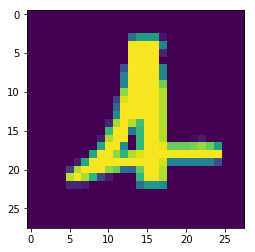

In [34]:
i = 11
plt.imshow(mis_X[i].reshape(28,28).T)
print('Actual:',mis_t[i])
print('Predicted:',mis_y[i])

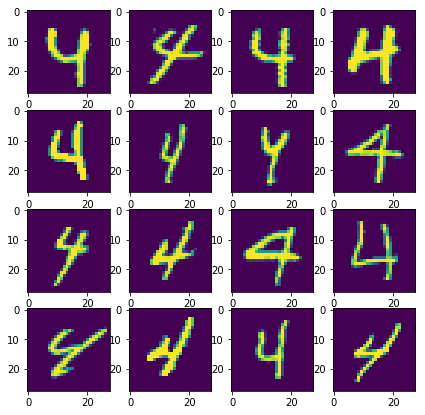

In [35]:
X_train_2 = X_train[t_train==4]
plt.figure(figsize=(7,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train_2[i].reshape((28,28)).T)